In [106]:
import sys
from math import cos, pi, sin, sqrt

import numpy as np
import sympy as sym
from matplotlib import pyplot as plt
from sympy.utilities import lambdify

location = "/home/gsalinas/GitHub/MyTransport/PyTransport" # This should be the location of the PyTransport folder folder
sys.path.append(location) # Sets up python path to give access to PyTransSetup

import PyTransSetup

PyTransSetup.pathSet()  # This adds the other paths that PyTransport uses to the python path

import PyTransAngular as PyT
import PyTransScripts as PyS

In [107]:
nF = 2  # number of fields
nP = 3  # number of parameters
f = sym.symarray('f',nF)   # an array representing the nF fields present for this model
p = sym.symarray('p',nP)   # an array representing the nP parameters needed to define this model, format [alpha, R]

V = p[0]/2 * p[2]**2 * (f[0]**2 + p[1]*f[1]**2)   # this is the potential written in sympy notation
G = 6 * p[0] / (1-f[0]**2-f[1]**2)**2 * sym.Matrix([[1, 0], [0, 1]]) # this is the field metric written in sympy notation

In [108]:
nF=PyT.nF()
nP=PyT.nP()

pval = np.array([1/600, 9, 2e-5]) # Parameter values, format [alpha, R, mphi]
r0, theta0 = 0.99, pi/4
fields = r0 * np.array([cos(theta0), sin(theta0)]) # Initial values of the fields [phi, chi]

In [109]:
V = PyT.V(fields, pval) # Calculate potential from some initial conditions
dV = PyT.dV(fields, pval) # Calculate derivatives of potential

phidot0 = np.zeros(2) # set initial conditions to be in slow roll
initial = np.concatenate((fields, phidot0)) # Sets an array containing field values and there derivative in cosmic time 

In [110]:
Nstart, Nend = 0., 100
Nsteps = 50_000_000
Nrange = np.linspace(Nstart, Nend, Nsteps)

tols = np.array([10**-12, 10**-30])
back = PyT.backEvolve(Nrange, initial, pval, tols, True)

45811542


In [111]:
Ns, phis, phidots =  back.T[0], back.T[1:nF+1], back.T[nF+1:]

In [112]:
Nend = Ns[-1]
print(f'Number of e-folds: {Nend:.3}')

Number of e-folds: 91.6


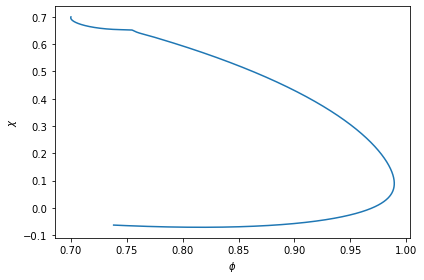

In [113]:
plt.plot(phis[0], phis[1])
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\chi$')
plt.tight_layout()

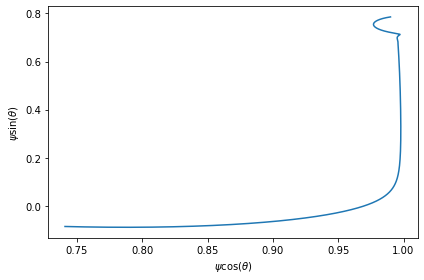

In [114]:
rs = np.sqrt(phis[0]**2 + phis[1]**2)
thetas = np.arctan(phis[1]/phis[0])
plt.plot(rs, thetas)
plt.xlabel(r'$\psi \cos(\theta)$')
plt.ylabel(r'$\psi \sin(\theta)$')
plt.tight_layout()

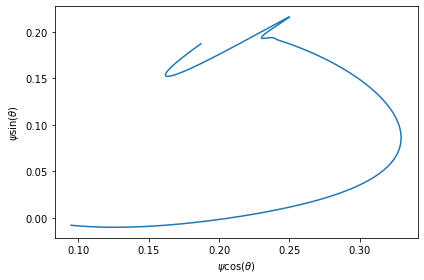

In [115]:
psis = sqrt(6*pval[0]) * np.arctanh(rs)
plt.plot(psis * np.cos(thetas), psis * np.sin(thetas))
plt.xlabel(r'$\psi \cos(\theta)$')
plt.ylabel(r'$\psi \sin(\theta)$')
plt.tight_layout()

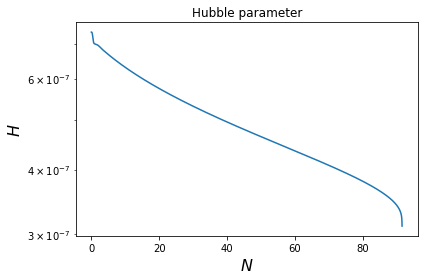

In [116]:
Hs = np.array([PyT.H(elem, pval) for elem in back[:, 1:]])
plt.plot(Ns, Hs)
plt.title('Hubble parameter')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$H$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

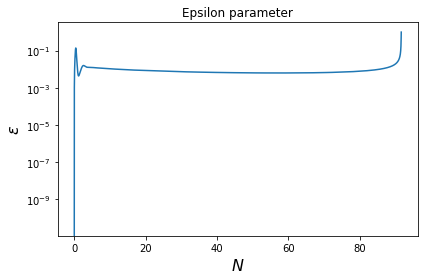

In [117]:
dN = Ns[1] - Ns[0]
epsilon = -np.gradient(Hs, dN)/Hs
plt.plot(Ns, epsilon)
plt.title('Epsilon parameter')
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'$\epsilon$', fontsize=16)
plt.yscale('log')
plt.tight_layout()

In [118]:
def dot_G(G_lbd, v1, v2, phi):
    return np.matmul(v1, np.matmul(G_lbd(phi[0], phi[1]), v2))

def mag_G(G_lbd, v, phi):
    return np.sqrt(dot_G(G_lbd, v, v, phi))

def e_pll(G_lbd, phi, phidot):
    return phidot / mag_G(G_lbd, phidot, phi)

def e_perp(G_lbd, phi, phidot):
    epll = e_pll(G_lbd, phi, phidot)
    e_perp_not_norm = np.array([epll[1], -epll[0]])
    return e_perp_not_norm / mag_G(G_lbd, e_perp_not_norm, phi)

In [119]:
G_lbd = lambdify(['f_0', 'f_1'], G.evalf(subs={'p_0': pval[0]}, n=100))

eplls = np.array([e_pll(G_lbd, phis.T[ii], phidots.T[ii]) for ii in range(len(phis.T))])
eperps = np.array([e_perp(G_lbd, phis.T[ii], phidots.T[ii]) for ii in range(len(phis.T))])

/tmp/ipykernel_3809458/2888876044.py:8: RuntimeWarning: invalid value encountered in true_divide
  return phidot / mag_G(G_lbd, phidot, phi)


In [120]:
NExit = Nend - 55
k = PyS.kexitN(NExit, back, pval, PyT) 

print(f'Horizon exit at N = {NExit:.3} with k = {k:.3}')

Horizon exit at N = 36.6 with k = 4.07e+09


In [121]:
NB = 8.0
Nstart, backExitMinus = PyS.ICsBE(NB, k, back, pval, PyT) # find conditions for NB e-folds before horizon crossing of k mode

print(f"2-pt calculation starts at: {Nstart:.3} e-folds")

2-pt calculation starts at: 28.6 e-folds


In [122]:
Nsig = Ns[Ns > Nstart]

# run the sigma routine to calc and plot the evolution of power spectrum value for this k -- can be
# repeated to build up the spectrum, here we run twice to get an crude estimate for ns
twoPt = PyT.sigEvolve(Nsig, k, backExitMinus, pval, tols, True) # puts information about the two point fuction in twoPt array
Nssig = twoPt[:, 0]
Pzeta = twoPt[:, 1] # the second column is the 2pt of zeta
sigma = twoPt[:, 1+1+2*nF:] # the last 2nF* 2nF columns correspond to the evolution of the sigma matrix

In [123]:
twoPt2 = PyT.sigEvolve(Nsig, k+.1*k, backExitMinus, pval, tols, True)
Pzeta2 = twoPt2[:,1]
n_s = (np.log(Pzeta2[-1])-np.log(Pzeta[-1])) / (np.log(k+.1*k)-np.log(k)) + 4.0
print(f'n_s: {n_s:.3f}')

n_s: 0.965


/tmp/ipykernel_3809458/784343698.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


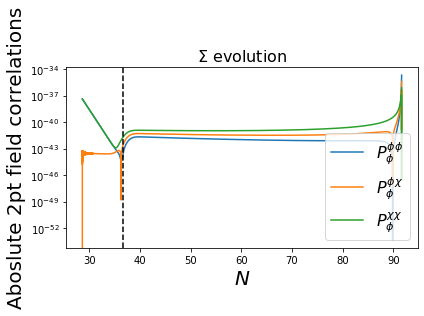

In [124]:
pairs = [(0,0), (0,1), (1,1)]
labels = ['$P^{\\phi\\phi}_\\phi$', '$P^{\\phi\\chi}_\\phi$', '$P^{\\chi\\chi}_\\phi$']
for ii, pair in enumerate(pairs):
    plt.plot(twoPt[:, 0], np.abs(sigma[:, pair[0] + 2*nF*pair[1]]), label=labels[ii])
plt.title(r'$\Sigma$ evolution',fontsize=16)
plt.legend(fontsize=16)
plt.ylabel(r'Aboslute 2pt field correlations', fontsize=20) 
plt.xlabel(r'$N$', fontsize=20)
plt.yscale('log')
plt.axvline(NExit, c='k', linestyle='--')
plt.tight_layout()

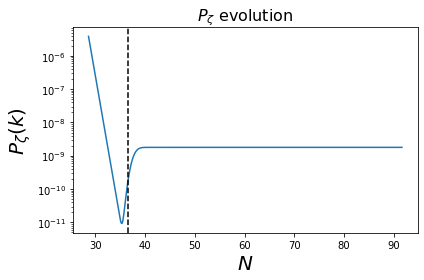

In [125]:
Pzeta_nodim = Pzeta * k**3 / 2 / np.pi**2
plt.plot(Nssig, Pzeta_nodim)
plt.axvline(NExit, c='k', linestyle='--')
plt.title(r'$P_\zeta$ evolution',fontsize=16);
plt.ylabel(r'$P_\zeta(k)$', fontsize=20) 
plt.xlabel(r'$N$', fontsize=20)
plt.yscale('log')
plt.tight_layout()

In [126]:
print(f'k: {k:.3}')
print(f'Power spectrum: {Pzeta_nodim[-1]:.3}')

i_exit_sig = np.argmin(np.abs(Nssig - NExit))
print(f'Power spectrum at horizon crossing: {Pzeta_nodim[i_exit_sig]:.3}')

k: 4.07e+09
Power spectrum: 1.79e-09
Power spectrum at horizon crossing: 2.05e-10


In [127]:
i_exit = np.argmin(np.abs(Ns - NExit))
shift = len(Ns) - len(Nsig)

i_exit_sig = i_exit - shift
# phis_exit, phidots_exit = phis.T[i_exit], phidots.T[i_exit]

In [128]:
# G_exit = G_lbd(phis_exit[0], phis_exit[1])
# epll_exit = eplls[i_exit]
# eperp_exit = eperps[i_exit]

# sigma_exit = np.concatenate((sigma[i_exit_sig][0:nF], sigma[i_exit_sig][2*nF:2*nF+2])).reshape(2,2)

In [129]:
def spec(phis: np.ndarray):
    PR, CRS, PS = [], [], []
    for i in range(shift, len(phis.T)):
        G_i = G_lbd(phis.T[i, 0], phis.T[i, 1])
        sigma_i = np.concatenate((sigma[i-shift][0:nF], sigma[i-shift][2*nF:2*nF+2])).reshape(2,2)
        PR.append(eplls[i] @ G_i @ sigma_i @ G_i @ eplls[i] * k**3 / 2 / np.pi**2 / 2 / epsilon[i])
        CRS.append(eperps[i] @ G_i @ sigma_i @ G_i @ eplls[i] * k**3 / 2 / np.pi**2 / 2 / epsilon[i])
        PS.append(eperps[i] @ G_i @ sigma_i @ G_i @ eperps[i] * k**3 / 2 / np.pi**2 / 2 / epsilon[i])

    return np.array(PR), np.array(CRS), np.array(PS)

In [130]:
# from decimal import Decimal, getcontext

# def vector_to_dec(vector):
#     return np.array([Decimal(elem) for elem in vector])

# def matrix_to_dec(matrix):
#     return np.array([[Decimal(elem) for elem in row] for row in matrix])

# def spec(phis: np.ndarray):
#     PR, CRS, PS = [], [], []
#     for i in range(shift, len(phis.T)):
#         G_i = matrix_to_dec(G_lbd(phis.T[i, 0], phis.T[i, 1]))
#         sigma_i = matrix_to_dec(np.concatenate((sigma[i-shift][0:nF], sigma[i-shift][2*nF:2*nF+2])).reshape(2,2))
#         PR.append(vector_to_dec(eplls[i]) @ G_i @ sigma_i @ G_i @ vector_to_dec(eplls[i]) * Decimal(k**3 / 2 / np.pi**2 / 2 / epsilon[i]))
#         CRS.append(vector_to_dec(eperps[i]) @ G_i @ sigma_i @ G_i @ vector_to_dec(eplls[i]) * Decimal(k**3 / 2 / np.pi**2 / 2 / epsilon[i]))
#         PS.append(vector_to_dec(eperps[i]) @ G_i @ sigma_i @ G_i @ vector_to_dec(eperps[i]) * Decimal(k**3 / 2 / np.pi**2 / 2 / epsilon[i]))

#     return np.array(PR), np.array(CRS), np.array(PS)

In [131]:
PR, CRS, PS = spec(phis)

In [132]:
# print(f"""PR at horizon crossing: {PR[i_exit-shift]}\n
# CRS at horizon crossing: {CRS[i_exit-shift]} \n
# PS at horizon crossing: {PS[i_exit-shift]}\n
# \n
# PR at the end of inflation: {PR[-1]}\n
# CRS at the end of inflation: {CRS[-1]}\n
# PS at the end of inflation: {PS[-1]}\n""")

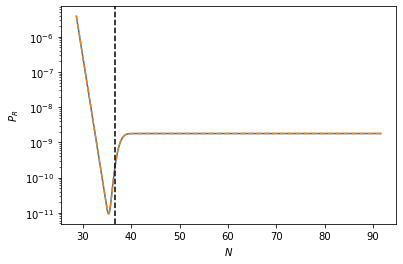

In [133]:
plt.plot(Nssig, PR)
plt.plot(Nssig, Pzeta_nodim, linestyle='--')
plt.yscale('log')
plt.xlabel(r"$N$")
plt.ylabel(r"$P_R$")
plt.axvline(NExit, c='k', linestyle='--')

In [134]:
np.save("CRS" + str(Nsteps), np.array(list(zip(Nssig, CRS))).T)

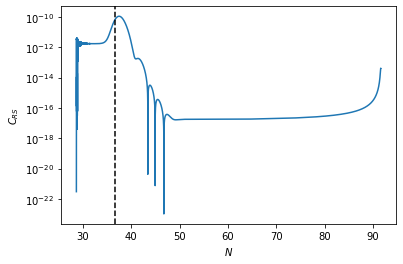

In [135]:
plt.plot(Nsig, abs(CRS))
plt.yscale('log')
plt.xlabel(r"$N$")
plt.ylabel(r"$C_{RS}$")
plt.axvline(NExit, c='k', linestyle='--')

/tmp/ipykernel_3809458/444806852.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(Nsig, abs(CRS) / np.sqrt(PR * PS))


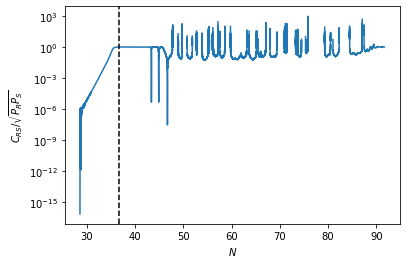

In [136]:
plt.plot(Nsig, abs(CRS) / np.sqrt(PR * PS))
plt.yscale('log')
plt.xlabel(r"$N$")
plt.ylabel(r"$C_{RS}/\sqrt{P_R P_S}$")
plt.axvline(NExit, c='k', linestyle='--')

In [137]:
np.save("PS" + str(Nsteps), np.array(list(zip(Nssig, PS))).T)

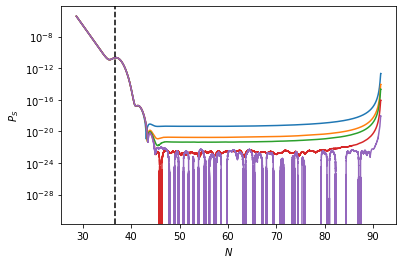

: 

In [138]:
plt.plot(np.load("PS100000.npy")[0], np.load("PS100000.npy")[1])
plt.plot(np.load("PS500000.npy")[0], np.load("PS500000.npy")[1])
plt.plot(np.load("PS1000000.npy")[0], np.load("PS1000000.npy")[1])
plt.plot(np.load("PS5000000.npy")[0], np.load("PS5000000.npy")[1])
plt.plot(np.load("PS50000000.npy")[0], np.load("PS50000000.npy")[1])
plt.yscale('log')
plt.xlabel(r"$N$")
plt.ylabel(r"$P_S$")
plt.axvline(NExit, c='k', linestyle='--')

In [33]:
PS_star = PS[i_exit_sig]
TSS = np.sqrt(PS / PS_star)

(36.624366243662436, 94.77389773897738)

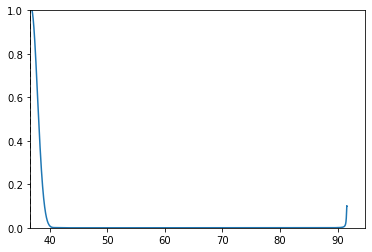

In [34]:
plt.plot(Nsig, TSS)
plt.ylim([0, 1])
plt.axvline(NExit, c='k', linestyle='--')
plt.xlim(left=Ns[i_exit])

In [35]:
CRS_star = abs(CRS[i_exit_sig])
PR_star = PR[i_exit_sig]

TRS = (abs(CRS) - TSS * CRS_star) / TSS / PS_star

(36.624366243662436, 94.77389773897738)

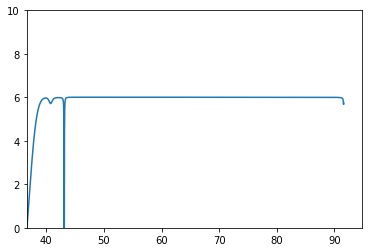

In [36]:
plt.plot(Nsig, TRS)
plt.ylim([0, 10])
plt.xlim(left=Ns[i_exit])

In [37]:
TRS2 = (-CRS_star + np.sqrt(CRS_star**2 + PR*PS_star - PR_star*PS_star)) / PS_star

(36.624366243662436, 94.77389773897738)

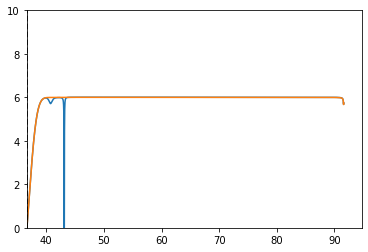

In [38]:
plt.plot(Nsig, TRS)
plt.plot(Nsig, TRS2)
plt.ylim([0, 10])
plt.axvline(NExit, c='k', linestyle='--')
plt.xlim(left=Ns[i_exit])

In [39]:
TRS[-1]

5.742899566027212

In [40]:
beta = abs(CRS[-1]) / sqrt(PR[-1] * PS[-1])
I4 = TRS[-1] * (1 - 2*TRS[-1]*beta*sqrt(PS[i_exit-shift]/PR[-1]) + (1+TRS[-1]**2)*beta**2*PS[i_exit-shift]/PR[-1])

In [41]:
I4

0.7663626088279734

In [42]:
I5 = beta * sqrt(PS[i_exit-shift]/PR[-1]) * (TRS[-1]-(1+TRS[-1]**2)*beta*sqrt(PS[i_exit-shift]/PR[-1]))

In [43]:
I5

0.21371863869527777

In [44]:
eperps[i_exit] @ PyT.ddV(phis.T[i_exit], pval) @ eperps[i_exit]

-1.4138458329447417e-12

In [45]:
# set three scales in FLS manner (using alpha, beta notation)
alpha = 0.
beta = 1/3.

k1 = k/2 - beta*k/2.
k2 = k/4*(1+alpha+beta)
k3 = k/4*(1-alpha+beta)

In [46]:
# find initial conditions for NB e-folds before the smallest k (which exits the horizon first) crosses the horizon
kM = np.min(np.array([k1, k2, k3]))
Nstart, backExitMinus = PyS.ICsBM(NB, kM, back, pval, PyT)
print(f"3-pt calculation starts at: {Nstart} e-folds")

# run the three point evolution for this triangle
talp = np.linspace(Nstart, Nend, 10_000)
threePt = PyT.alphaEvolve(talp, k1, k2, k3, backExitMinus, pval, tols, True) # all data from three point run goes into threePt array
alpha = threePt[:,1+4+2*nF+6*2*nF*2*nF:]        # this now contains the 3pt of the fields and field derivative pertruabtions
zzz = threePt[:,1:5] # this contains the evolution of two point of zeta for each k mode involved and the 3pt of zeta

In [ ]:
for ii in range(0,2):
    for jj in range(0,2):
        for kk in range(0,2):
            plt.plot(talp, np.abs(alpha[:,ii + 2*nF*jj + 2*nF*2*nF*kk]))
plt.title(r'$\alpha$ evolution',fontsize=15)
plt.ylabel(r'Absolute 3pt field correlations', fontsize=20)
plt.xlabel(r'$N$', fontsize=15)
plt.yscale('log')
plt.tight_layout()

NameError: name 'plt' is not defined

In [ ]:
fnl = 5.0/6.0*zzz[:,3]/(zzz[:,1]*zzz[:,2]  + zzz[:,0]*zzz[:,1] + zzz[:,0]*zzz[:,2])
plt.plot(talp, fnl,'r')
plt.title(r'$f_{NL}$ evolution',fontsize=15)
plt.ylabel(r'$f_{NL}$', fontsize=20)
plt.xlabel(r'$N$', fontsize=15)
plt.tight_layout()